In [2]:
import warnings 
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import json

2024-04-27 20:32:40.585580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 20:32:40.585679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 20:32:40.728719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [4]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [5]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [6]:
min_num_of_products_in_sequence = 5
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 252156


In [7]:
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [8]:
sequence_length = 35

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [9]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [10]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11424, 5089, 1

In [11]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1489192
Number of validation sequences: 252156
Number of test sequences: 252156

Number of train targets: 1489192
Number of validation targets: 252156
Number of test targets: 252156


In [12]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

#### Preprocessing datasets for faster processing

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [14]:
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### F1@k

In [16]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [17]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [18]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [19]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

# Training and evaluating models

## LSTM

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [20]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
    9/23269 ━━━━━━━━━━━━━━━━━━━━ 5:57 15ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 0.0013 - hit_rate_at_k: 0.0013 - loss: 11.8819 - ndcg_at_k: 2.7701e-04         

I0000 00:00:1714227457.678197     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 358s 15ms/step - accuracy: 0.0344 - f1_score_at_k: 0.0281 - hit_rate_at_k: 0.0576 - loss: 9.6622 - ndcg_at_k: 0.0158 - val_accuracy: 0.0529 - val_f1_score_at_k: 0.0593 - val_hit_rate_at_k: 0.0736 - val_loss: 9.4847 - val_ndcg_at_k: 0.0217
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 341s 15ms/step - accuracy: 0.0585 - f1_score_at_k: 0.0619 - hit_rate_at_k: 0.0909 - loss: 8.9446 - ndcg_at_k: 0.0256 - val_accuracy: 0.0653 - val_f1_score_at_k: 0.0689 - val_hit_rate_at_k: 0.0848 - val_loss: 9.3998 - val_ndcg_at_k: 0.0258
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 340s 15ms/step - accuracy: 0.0682 - f1_score_at_k: 0.0725 - hit_rate_at_k: 0.1014 - loss: 8.7921 - ndcg_at_k: 0.0291 - val_accuracy: 0.0721 - val_f1_score_at_k: 0.0733 - val_hit_rate_at_k: 0.0909 - val_loss: 9.3740 - val_ndcg_at_k: 0.0279
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 339s 15ms/step - accuracy: 0.0738 - f1_score_at_k: 0.0771 - hit_rate_at_k: 0.1069 - loss: 8.7075 - ndcg_at_k: 0.0310 -

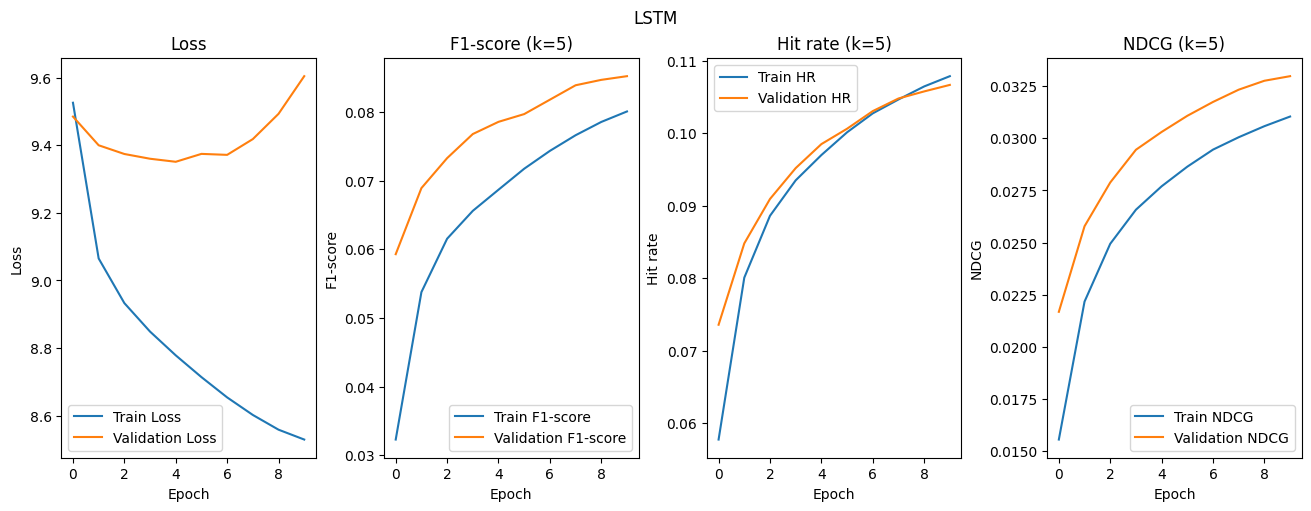

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('LSTM')
plt.show()

In [22]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score"] = round(model_lstm_test_f1_score, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0806 - f1_score_at_k: 0.0791 - hit_rate_at_k: 0.0955 - loss: nan - ndcg_at_k: 0.0300
Test loss: nan
Test accuracy: 0.0649
Test F1@5: 0.0644
Test HR@5: 0.0792
Test NDCG@5: 0.0245


In [23]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 35,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0649,
 'model_lstm_test_f1_score': 0.0644,
 'model_lstm_test_hr': 0.0792,
 'model_lstm_test_ndcg': 0.0245}

---------

## Bidirectional-LSTM

In [20]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [21]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
    3/23269 ━━━━━━━━━━━━━━━━━━━━ 10:23 27ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 0.0000e+00 - hit_rate_at_k: 0.0000e+00 - loss: 11.8813 - ndcg_at_k: 0.0000e+00   

I0000 00:00:1714250261.328631     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 580s 24ms/step - accuracy: 0.0357 - f1_score_at_k: 0.0301 - hit_rate_at_k: 0.0589 - loss: 9.6582 - ndcg_at_k: 0.0162 - val_accuracy: 0.0537 - val_f1_score_at_k: 0.0574 - val_hit_rate_at_k: 0.0721 - val_loss: 9.6319 - val_ndcg_at_k: 0.0215
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 553s 24ms/step - accuracy: 0.0601 - f1_score_at_k: 0.0628 - hit_rate_at_k: 0.0904 - loss: 9.0190 - ndcg_at_k: 0.0258 - val_accuracy: 0.0637 - val_f1_score_at_k: 0.0674 - val_hit_rate_at_k: 0.0833 - val_loss: 9.5508 - val_ndcg_at_k: 0.0251
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 554s 24ms/step - accuracy: 0.0697 - f1_score_at_k: 0.0709 - hit_rate_at_k: 0.0999 - loss: 8.8520 - ndcg_at_k: 0.0291 - val_accuracy: 0.0712 - val_f1_score_at_k: 0.0729 - val_hit_rate_at_k: 0.0885 - val_loss: 16.5938 - val_ndcg_at_k: 0.0273
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 553s 24ms/step - accuracy: 0.0771 - f1_score_at_k: 0.0774 - hit_rate_at_k: 0.1068 - loss: 8.7444 - ndcg_at_k: 0.0315 

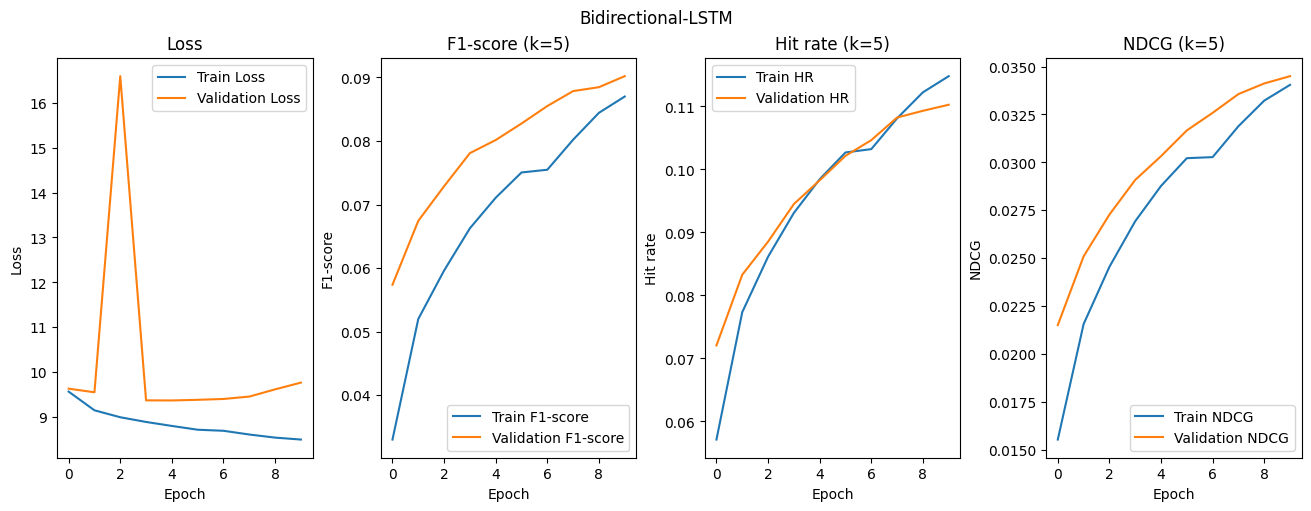

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [23]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.0843 - f1_score_at_k: 0.0834 - hit_rate_at_k: 0.0990 - loss: nan - ndcg_at_k: 0.0312
Test loss: nan
Test accuracy: 0.0684
Test F1@5: 0.0685
Test HR@5: 0.0822
Test NDCG@5: 0.0256


In [24]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 35,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0684,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.0822,
 'model_bi_lstm_test_ndcg': 0.0256}

-----------

## GRU

In [25]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [26]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 396s 17ms/step - accuracy: 0.0354 - f1_score_at_k: 0.0312 - hit_rate_at_k: 0.0603 - loss: 9.6653 - ndcg_at_k: 0.0164 - val_accuracy: 0.0502 - val_f1_score_at_k: 0.0571 - val_hit_rate_at_k: 0.0723 - val_loss: 9.5723 - val_ndcg_at_k: 0.0210
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 376s 16ms/step - accuracy: 0.0536 - f1_score_at_k: 0.0575 - hit_rate_at_k: 0.0859 - loss: 9.0493 - ndcg_at_k: 0.0240 - val_accuracy: 0.0622 - val_f1_score_at_k: 0.0659 - val_hit_rate_at_k: 0.0816 - val_loss: 9.4535 - val_ndcg_at_k: 0.0246
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 376s 16ms/step - accuracy: 0.0619 - f1_score_at_k: 0.0676 - hit_rate_at_k: 0.0959 - loss: 8.8764 - ndcg_at_k: 0.0271 - val_accuracy: 0.0688 - val_f1_score_at_k: 0.0723 - val_hit_rate_at_k: 0.0886 - val_loss: 9.3967 - val_ndcg_at_k: 0.0269
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 376s 16ms/step - accuracy: 0.0673 - f1_score_at_k: 0.0722 - hit_rate_at_k: 0.1020 - loss: 8.7827 - ndcg_at_

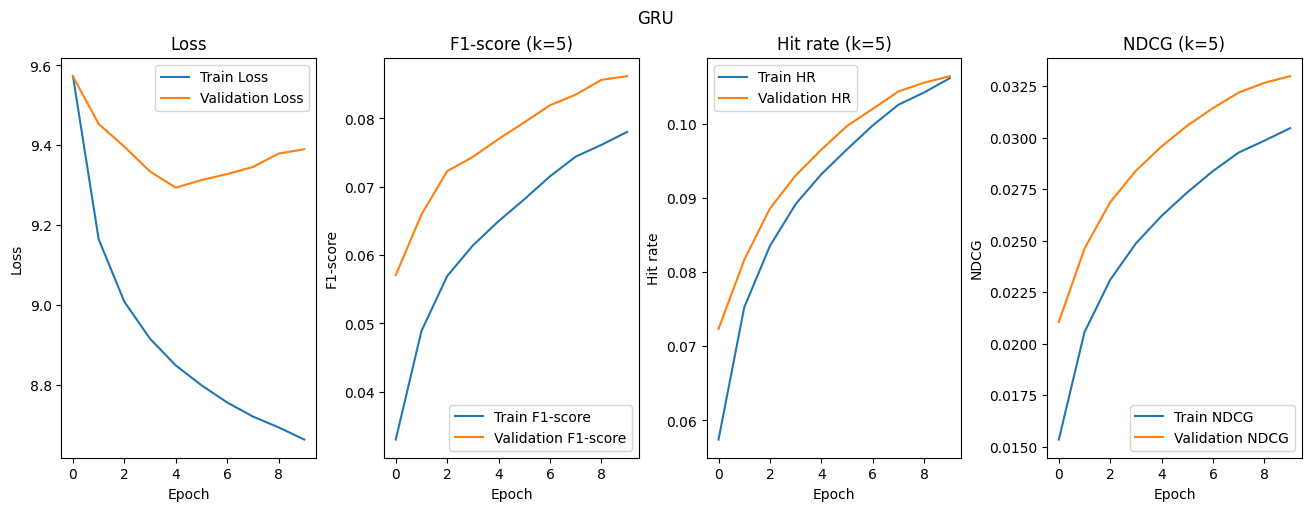

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('GRU')
plt.show()

In [28]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@5:", round(model_gru_test_f1_score, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score"] = round(model_gru_test_f1_score, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0803 - f1_score_at_k: 0.0803 - hit_rate_at_k: 0.0951 - loss: nan - ndcg_at_k: 0.0298
Test loss: nan
Test accuracy: 0.065
Test F1@5: 0.0656
Test HR@5: 0.0789
Test NDCG@5: 0.0245


In [29]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 35,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0684,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.0822,
 'model_bi_lstm_test_ndcg': 0.0256,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.065,
 'model_gru_test_f1_score': 0.0656,
 'model_gru_test_hr': 0.0789,
 'model_gru_test_ndcg': 0.0245}

--------

## Autoencoder

In [30]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [31]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   19/23269 ━━━━━━━━━━━━━━━━━━━━ 3:18 9ms/step - accuracy: 0.0000e+00 - f1_score_at_k: 5.7568e-04 - hit_rate_at_k: 0.0011 - loss: 11.8831 - ndcg_at_k: 1.7196e-04      

W0000 00:00:1714259653.245800     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0249 - f1_score_at_k: 0.0169 - hit_rate_at_k: 0.0473 - loss: 9.7952 - ndcg_at_k: 0.0124

W0000 00:00:1714259860.949174     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 237s 10ms/step - accuracy: 0.0249 - f1_score_at_k: 0.0169 - hit_rate_at_k: 0.0473 - loss: 9.7952 - ndcg_at_k: 0.0124 - val_accuracy: 0.0371 - val_f1_score_at_k: 0.0459 - val_hit_rate_at_k: 0.0608 - val_loss: 9.4466 - val_ndcg_at_k: 0.0168
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 210s 9ms/step - accuracy: 0.0391 - f1_score_at_k: 0.0422 - hit_rate_at_k: 0.0745 - loss: 8.9735 - ndcg_at_k: 0.0195 - val_accuracy: 0.0484 - val_f1_score_at_k: 0.0581 - val_hit_rate_at_k: 0.0749 - val_loss: 9.3616 - val_ndcg_at_k: 0.0211
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 210s 9ms/step - accuracy: 0.0471 - f1_score_at_k: 0.0519 - hit_rate_at_k: 0.0849 - loss: 8.8784 - ndcg_at_k: 0.0227 - val_accuracy: 0.0507 - val_f1_score_at_k: 0.0635 - val_hit_rate_at_k: 0.0807 - val_loss: 9.4030 - val_ndcg_at_k: 0.0226
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 210s 9ms/step - accuracy: 0.0508 - f1_score_at_k: 0.0579 - hit_rate_at_k: 0.0905 - loss: 8.8272 - ndcg_at_k: 0.0243 - va

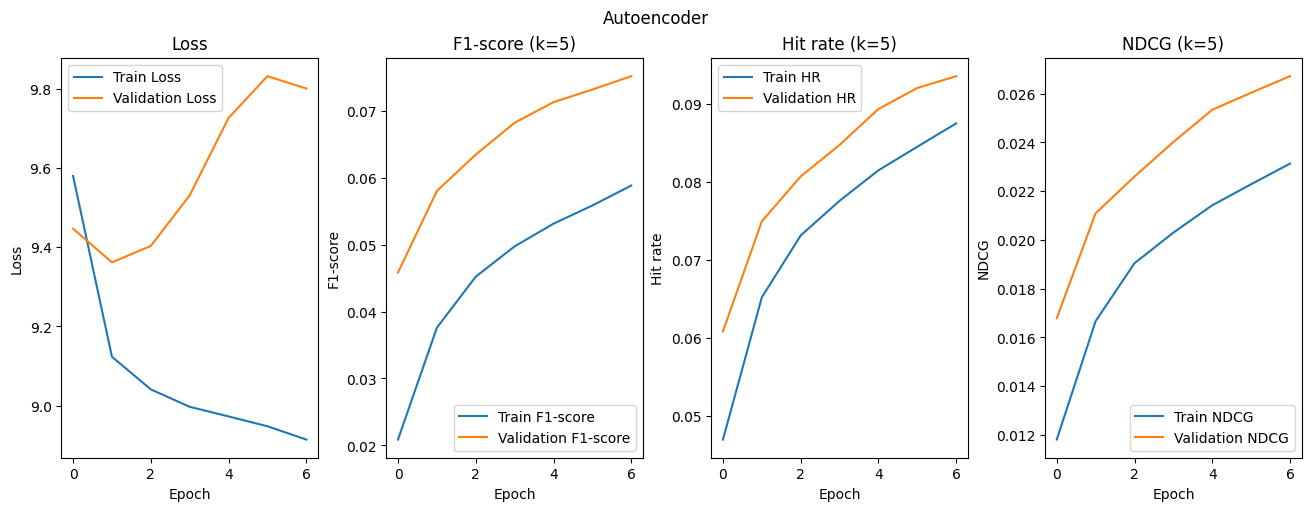

In [32]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Autoencoder')
plt.show()

In [33]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score"] = round(model_autoencoder_test_f1_score, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0553 - f1_score_at_k: 0.0712 - hit_rate_at_k: 0.0831 - loss: nan - ndcg_at_k: 0.0238
Test loss: nan
Test accuracy: 0.042
Test F1@5: 0.0563
Test HR@5: 0.0672
Test NDCG@5: 0.0188


In [34]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 35,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0684,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.0822,
 'model_bi_lstm_test_ndcg': 0.0256,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.065,
 'model_gru_test_f1_score': 0.0656,
 'model_gru_test_hr': 0.0789,
 'model_gru_test_ndcg': 0.0245,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.042,
 'model_autoencoder_test_f1_score': 0.0563,
 'model_autoencoder_test_hr': 0.0672,
 'model_autoencoder_test_ndcg': 0.0188}

-------

## CNN

In [35]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
#model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(max_product_id, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [36]:
history_model_cnn = model_cnn.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - accuracy: 0.0431 - f1_score_at_k: 0.0375 - hit_rate_at_k: 0.0646 - loss: 9.6098 - ndcg_at_k: 0.0184 - val_accuracy: 0.0550 - val_f1_score_at_k: 0.0577 - val_hit_rate_at_k: 0.0722 - val_loss: 9.6697 - val_ndcg_at_k: 0.0218
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 181s 8ms/step - accuracy: 0.0679 - f1_score_at_k: 0.0659 - hit_rate_at_k: 0.0942 - loss: 8.9874 - ndcg_at_k: 0.0277 - val_accuracy: 0.0677 - val_f1_score_at_k: 0.0655 - val_hit_rate_at_k: 0.0845 - val_loss: 9.6569 - val_ndcg_at_k: 0.0260
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 181s 8ms/step - accuracy: 0.0774 - f1_score_at_k: 0.0748 - hit_rate_at_k: 0.1040 - loss: 8.7770 - ndcg_at_k: 0.0310 - val_accuracy: 0.0719 - val_f1_score_at_k: 0.0711 - val_hit_rate_at_k: 0.0892 - val_loss: 9.5546 - val_ndcg_at_k: 0.0275
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 180s 8ms/step - accuracy: 0.0826 - f1_score_at_k: 0.0793 - hit_rate_at_k: 0.1094 - loss: 8.6602 - ndcg_at_k: 0

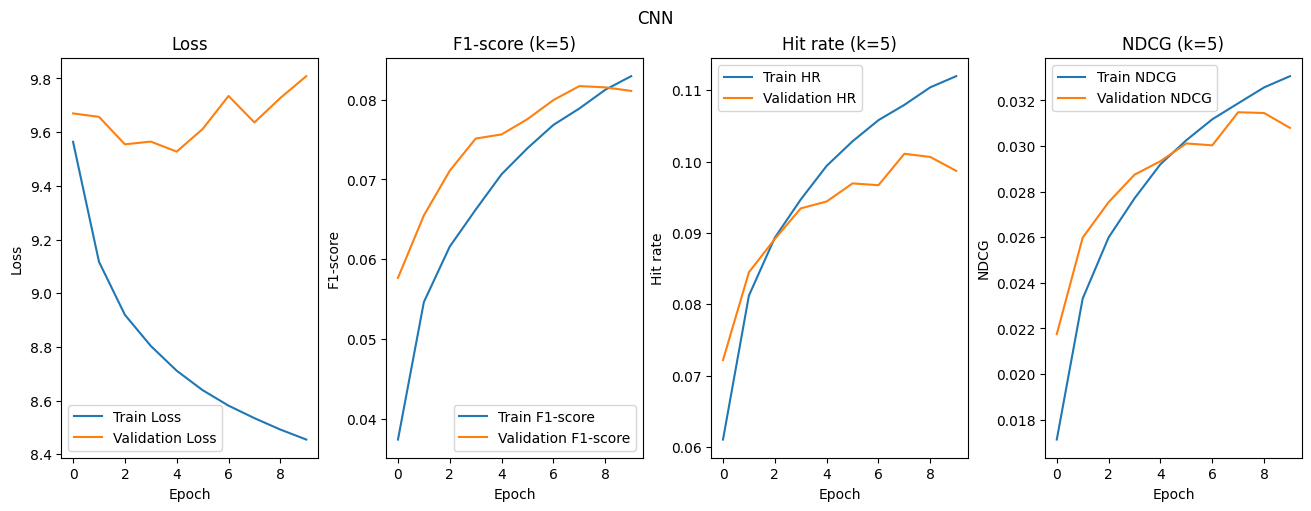

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_cnn.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_cnn.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_cnn.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_cnn.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('CNN')
plt.show()

In [38]:
model_cnn_test_loss, model_cnn_test_accuracy, model_cnn_test_f1_score, model_cnn_test_hr, model_cnn_test_ndcg = model_cnn.evaluate(test_dataset)

print("Test loss:", round(model_cnn_test_loss, 4))
print("Test accuracy:", round(model_cnn_test_accuracy, 4))
print("Test F1@5:", round(model_cnn_test_f1_score, 4))
print("Test HR@5:", round(model_cnn_test_hr, 4))
print("Test NDCG@5:", round(model_cnn_test_ndcg, 4))

parameters["model_cnn_test_loss"] = model_cnn_test_loss
parameters["model_cnn_test_accuracy"] = round(model_cnn_test_accuracy, 4)
parameters["model_cnn_test_f1_score"] = round(model_cnn_test_f1_score, 4)
parameters["model_cnn_test_hr"] = round(model_cnn_test_hr, 4)
parameters["model_cnn_test_ndcg"] = round(model_cnn_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0758 - f1_score_at_k: 0.0749 - hit_rate_at_k: 0.0901 - loss: nan - ndcg_at_k: 0.0283
Test loss: nan
Test accuracy: 0.0597
Test F1@5: 0.0601
Test HR@5: 0.0734
Test NDCG@5: 0.0227


------

In [39]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 35,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0684,
 'model_bi_lstm_test_f1_score': 0.0685,
 'model_bi_lstm_test_hr': 0.0822,
 'model_bi_lstm_test_ndcg': 0.0256,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.065,
 'model_gru_test_f1_score': 0.0656,
 'model_gru_test_hr': 0.0789,
 'model_gru_test_ndcg': 0.0245,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.042,
 'model_autoencoder_test_f1_score': 0.0563,
 'model_autoencoder_test_hr': 0.0672,
 'model_autoencoder_test_ndcg': 0.0188,
 'model_cnn_test_loss': nan,
 'model_cnn_test_accuracy': 0.0597,
 'model_cnn_test_f1_score': 0.0601,
 'm